5-fold CV AUC: mean=1.0000, std=0.0000
Train AUC: 1.0


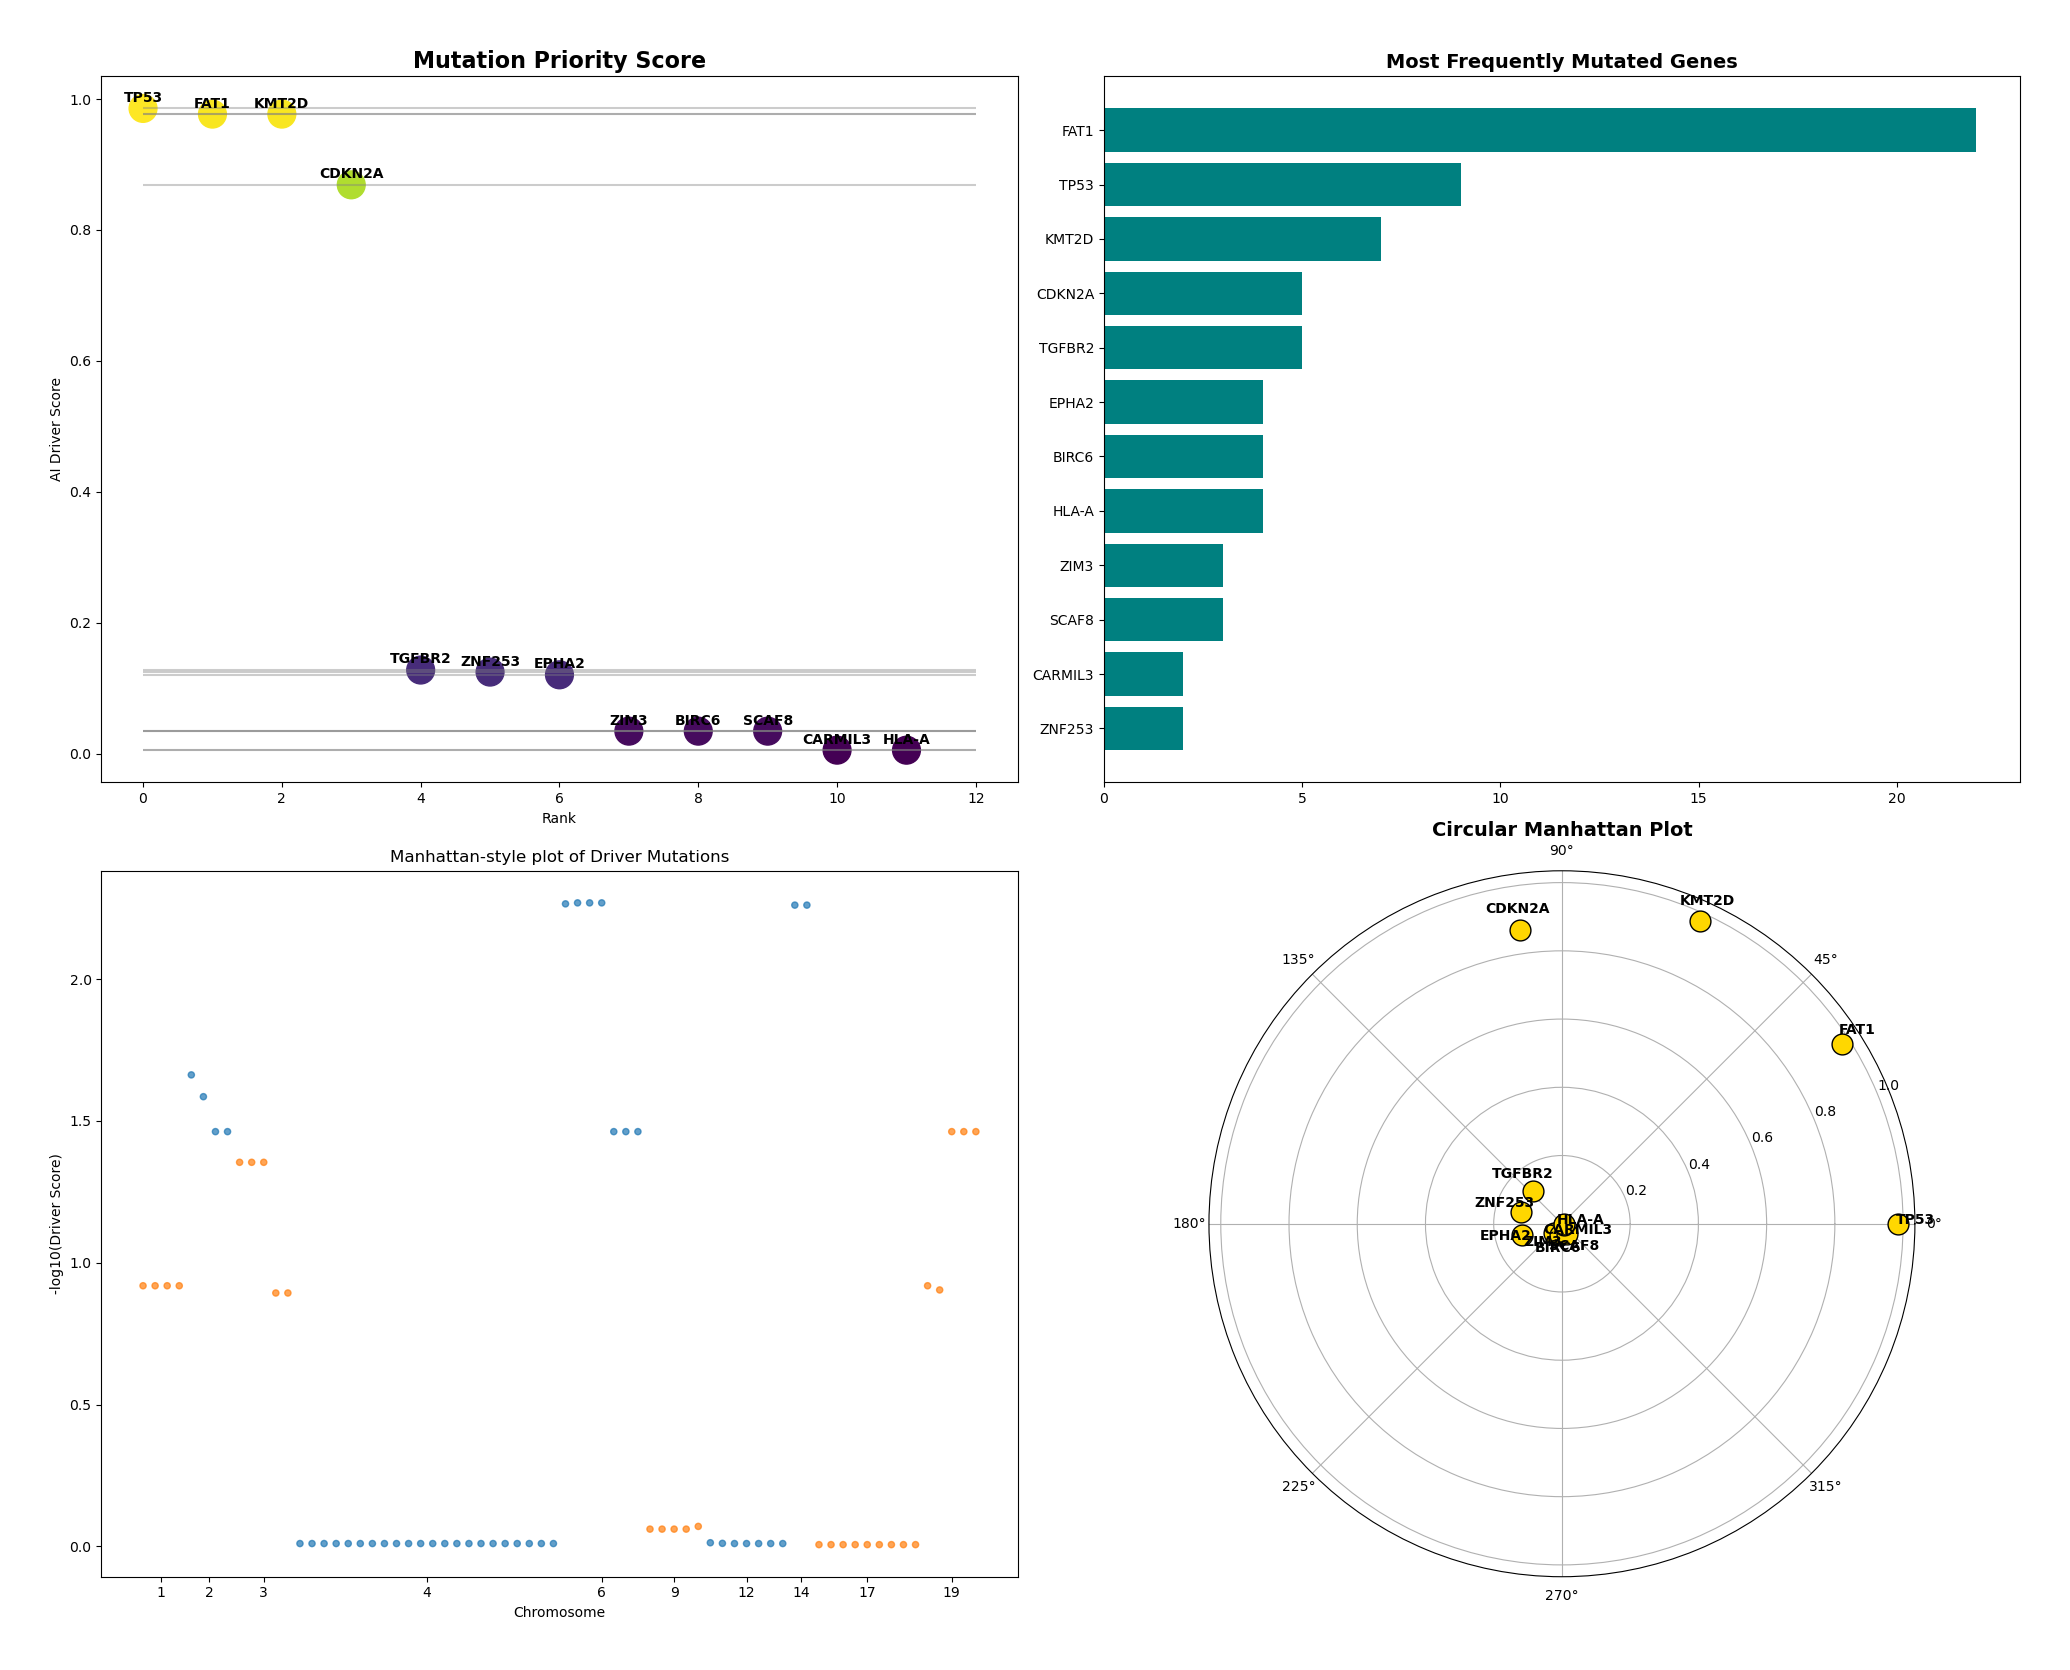

In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


# --- Helper function to choose columns ---
def choose_column(df, candidates, default=None):
    for c in candidates:
        if c in df.columns:
            return c
    return default

# ---------------- Load datasets ----------------
df_sbs = pd.read_csv("SBS_Signature_HNSC.csv")
gene_var = pd.read_csv("gene_variants.csv", skiprows=1)
testset = pd.read_csv("test.csv")
try:
    roh = pd.read_csv("ROH.csv")
except:
    roh = pd.read_csv("ROH.csv", encoding_errors="replace")

# Strip column names
for df in [df_sbs, testset, roh, gene_var]:
    df.columns = df.columns.str.strip()

# ---------------- Prepare SBS function ----------------
def prepare_sbs(df_input):
    sbs = df_input.copy()
    
    # Gene column
    gene_col = choose_column(sbs, ['Gene','HUGO symbol'])
    if gene_col is None:
        sbs['Gene'] = 'unknown'
    else:
        sbs['Gene'] = sbs[gene_col].astype(str).str.strip()
    
    # SBS signature
    sbs_col = choose_column(sbs, ['SBS signature','SBS_signature','SBS'])
    if sbs_col:
        sbs = sbs.rename(columns={sbs_col: 'SBS_signature'})
    else:
        sbs['SBS_signature'] = 'unknown'
    
    # Nonsense mutations
    if 'Tumour amino acid' in sbs.columns:
        sbs['nonsense'] = sbs['Tumour amino acid'].astype(str).str.contains(r'\*', na=False).astype(int)
    else:
        sbs['nonsense'] = 0
    
    # Frameshift mutations
    frameshift_col = choose_column(sbs, ['Variant class','Variant_class','Variant type','Variant_Type'])
    if frameshift_col:
        sbs['frameshift'] = sbs[frameshift_col].astype(str).str.contains('frame', case=False, na=False).astype(int)
    else:
        sbs['frameshift'] = 0
    
    # Recurrent mutations
    sbs['recurrent'] = sbs.groupby('Gene')['Gene'].transform('count').astype(int)
    
    # Chromosome
    chrom_col = choose_column(sbs, ['Chrom','Chromosome','Chromosome no.'])
    if chrom_col:
        sbs['Chrom'] = sbs[chrom_col].astype(str)
    else:
        sbs['Chrom'] = '0'
    
    # Position
    pos_col = choose_column(sbs, ['Position','Start'])
    if pos_col:
        sbs['Position'] = pd.to_numeric(sbs[pos_col], errors='coerce').fillna(0)
    else:
        sbs['Position'] = 0
    
    # Sample ID
    sample_id_col = choose_column(sbs, ['Sample id','SampleID','Tumor sample barcode','Dataset'])
    
    return sbs, sample_id_col

# ---------------- Endogamy index ----------------
def add_endogamy(sbs, roh):
    # ROH summary
    roh_id_col = choose_column(roh, ['SampleID','Sample ID','sample_id','Sample'])
    if roh_id_col:
        roh['_sample'] = roh[roh_id_col].astype(str)
        if 'kb' in roh.columns:
            roh_summary = roh.groupby('_sample').agg({'kb': ['sum','mean','count']})
            roh_summary.columns = ['roh_total_kb','roh_mean_kb','roh_count']
            roh_summary = roh_summary.reset_index()
            if 'SampleID' in sbs.columns:
                sbs = sbs.merge(roh_summary, left_on='SampleID', right_on='_sample', how='left')
    
    # Fill missing
    for col in ['roh_total_kb','roh_mean_kb','roh_count']:
        if col not in sbs.columns:
            sbs[col] = 0.0
        else:
            sbs[col] = sbs[col].fillna(sbs[col].mean())
    
    # Gene frequency
    gene_counts = sbs['Gene'].value_counts().rename('gene_count').reset_index().rename(columns={'index':'Gene'})
    sbs = sbs.merge(gene_counts, on='Gene', how='left')
    sbs['gene_freq_norm'] = (sbs['gene_count'] - sbs['gene_count'].min()) / \
                            (sbs['gene_count'].max() - sbs['gene_count'].min() + 1e-9)
    
    # ROH normalized
    sbs['roh_norm'] = (sbs['roh_total_kb'] - sbs['roh_total_kb'].min()) / \
                      (sbs['roh_total_kb'].max() - sbs['roh_total_kb'].min() + 1e-9)
    
    # Endogamy index
    sbs['endogamy_index_raw'] = 0.4*sbs['roh_norm'] + 0.1*sbs['gene_freq_norm']
    sbs['endogamy_index'] = (sbs['endogamy_index_raw'] - sbs['endogamy_index_raw'].min()) / \
                            (sbs['endogamy_index_raw'].max() - sbs['endogamy_index_raw'].min() + 1e-9)
    
    return sbs

# ---------------- Prepare train and test ----------------
sbs_train, sample_id_col_train = prepare_sbs(df_sbs)
sbs_test, sample_id_col_test = prepare_sbs(testset)

sbs_train = add_endogamy(sbs_train, roh)
sbs_test = add_endogamy(sbs_test, roh)

# ---------------- Feature matrix ----------------
numeric_base = ['frameshift','recurrent','Position','gene_count','endogamy_index','roh_mean_kb']
X_train = sbs_train[numeric_base].copy()
X_test = sbs_test[numeric_base].copy()

# Map target using Gene column in gene_var
gene_col_in_var = choose_column(gene_var, ['Gene','Gene name','HUGO symbol'])
y_train = sbs_train['Gene'].apply(lambda x: 1 if x in gene_var[gene_col_in_var].values else 0).astype(int)

# ---------------- Train XGBoost ----------------
clf = xgb.XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method='hist',
    enable_categorical=True,
    eval_metric='auc',
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
print(f"5-fold CV AUC: mean={cv_scores.mean():.4f}, std={cv_scores.std():.4f}")

clf.fit(X_train, y_train)
sbs_train['DRIVER_SCORE'] = clf.predict_proba(X_train)[:,1]
sbs_test['DRIVER_SCORE'] = clf.predict_proba(X_test)[:,1]
print("Train AUC:", roc_auc_score(y_train, sbs_train['DRIVER_SCORE']))

# ---------------- Plotting ----------------
top30 = sbs_train.sort_values('DRIVER_SCORE', ascending=False).drop_duplicates('Gene').head(30)

plt.figure(figsize=(20,16))

# 1. Driver Score
plt.subplot(2,2,1)
n = len(top30)
plt.hlines(y=top30['DRIVER_SCORE'], xmin=0, xmax=n, color='gray', alpha=0.4)
plt.scatter(range(n), top30['DRIVER_SCORE'].values, c=top30['DRIVER_SCORE'].values, cmap='viridis', s=400)
for i, gene in enumerate(top30['Gene'].values):
    plt.text(i, top30['DRIVER_SCORE'].values[i]+0.01, gene, ha='center', fontweight='bold')
plt.title('Mutation Priority Score', fontsize=16, fontweight='bold')
plt.ylabel('AI Driver Score')
plt.xlabel('Rank')

# 2. Mutation Frequency
plt.subplot(2,2,2)
gene_counts = df_sbs['Gene'].value_counts().head(30)
plt.barh(range(len(gene_counts)), gene_counts.values, color='teal')
plt.yticks(range(len(gene_counts)), gene_counts.index)
plt.gca().invert_yaxis()
plt.title('Most Frequently Mutated Genes', fontsize=14, fontweight='bold')

# 3. Manhattan-style plot
plt.subplot(2,2,3)
df_plot = sbs_train.copy()
def chrom_to_num(chrom):
    if chrom in ['X','x']: return 23
    elif chrom in ['Y','y']: return 24
    else:
        try: return int(chrom)
        except: return 0
df_plot['chrom_num'] = df_plot['Chrom'].astype(str).apply(chrom_to_num)
df_plot = df_plot.sort_values(['chrom_num','Position']).reset_index(drop=True)
df_plot['pos'] = range(len(df_plot))
colors = ['#1f77b4', '#ff7f0e']
df_plot['color'] = df_plot['chrom_num'] % 2
df_plot['color'] = df_plot['color'].apply(lambda x: colors[int(x)])
plt.scatter(df_plot['pos'], -np.log10(df_plot['DRIVER_SCORE'] + 1e-5),
            c=df_plot['color'], s=20, alpha=0.7)
plt.xlabel("Chromosome")
plt.ylabel("-log10(Driver Score)")
plt.title("Manhattan-style plot of Driver Mutations")
plt.xticks(
    ticks=[df_plot[df_plot['chrom_num']==i]['pos'].median() for i in range(1,25)],
    labels=[str(i) for i in range(1,23)] + ['X','Y']
)

# 4. Circular Genome Plot 
top30 = top30.reset_index(drop=True)
plt.subplot(2,2,4, projection='polar')
theta = np.linspace(0, 2*np.pi, len(top30))
radius = top30['DRIVER_SCORE']
plt.polar(theta, radius, 'o', markersize=15, markerfacecolor='gold', markeredgecolor='black')
plt.title('Circular Manhattan Plot', fontsize=14, fontweight='bold')
for i, gene in enumerate(top30['Gene']):
    plt.text(theta[i], radius[i]+0.05, gene, ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig("RESULT.png", dpi=600, bbox_inches='tight')
plt.show()

# ---------------- Save results ----------------
sbs_train.to_csv("RESULT_TRAIN_SCORED.csv", index=False)
sbs_test.to_csv("RESULT_TEST_SCORED.csv", index=False)
top30[['Gene','DRIVER_SCORE']].to_csv("RESULT_TOP30.csv", index=False)
